## Evaluating my KG on OGB dataset

In [1]:
import pandas as pd
import json
import numpy as np

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch_geometric.utils import negative_sampling
import torch_geometric.transforms as T

from ogb.linkproppred import Evaluator, PygLinkPropPredDataset

from pykeen.evaluation import RankBasedEvaluator
from pykeen.triples import CoreTriplesFactory
from pykeen.pipeline import pipeline, pipeline_from_config 

/usr/local/lib/python3.8/dist-packages/pykeen/evaluation/evaluator.py:16: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
dataset_dir = '../data/dataset-ogb/'

### Load and prepare data

In [8]:
dataset = PygLinkPropPredDataset(name='ogbl-ddi', root=dataset_dir, transform=T.ToSparseTensor())
data = dataset[0]
data.adj_t

SparseTensor(row=tensor([   0,    0,    0,  ..., 4266, 4266, 4266]),
             col=tensor([   4,    6,    7,  ..., 3953, 3972, 4014]),
             size=(4267, 4267), nnz=2135822, density=11.73%)

In [9]:
split_edge = dataset.get_edge_split()
train_edge, valid_edge, test_edge = split_edge["train"], split_edge["valid"], split_edge["test"]
train_edge

{'edge': tensor([[4039, 2424],
         [4039,  225],
         [4039, 3901],
         ...,
         [ 647,  708],
         [ 708,  338],
         [ 835, 3554]])}

In [10]:
print(valid_edge['edge_neg'].shape)
print(valid_edge['edge'].shape)

torch.Size([101882, 2])
torch.Size([133489, 2])


In [7]:
def convert_to_triples_factory(data, num_entities, num_relations):
    
    tf_data = CoreTriplesFactory(
        data,
        num_entities = num_entities,
        num_relations = num_relations
    )

    print(tf_data)

    return tf_data

In [18]:
# add relation type - interacts with

train = train_edge['edge']
train = torch.tensor([[x[0], 0, x[1]] for x in train])
train_df = pd.DataFrame(train, columns=['head', 'relation', 'tail'])

valid = valid_edge['edge']
valid = torch.tensor([[x[0], 0, x[1]] for x in valid])
valid_df = pd.DataFrame(valid, columns=['head', 'relation', 'tail'])

valid_neg = valid_edge['edge_neg']
valid_neg = torch.tensor([[x[0], 0, x[1]] for x in valid_neg])

test = test_edge['edge']
test = torch.tensor([[x[0], 0, x[1]] for x in test])
test_df = pd.DataFrame(test, columns=['head', 'relation', 'tail'])

test_neg = test_edge['edge_neg']
test_neg = torch.tensor([[x[0], 0, x[1]] for x in test_neg])

num_entities = data.num_nodes

train_tf = convert_to_triples_factory(torch.tensor(train_df.values), num_entities, 1)
valid_tf = convert_to_triples_factory(torch.tensor(valid_df.values), num_entities, 1)
test_tf = convert_to_triples_factory(torch.tensor(test_df.values), num_entities, 1)

CoreTriplesFactory(num_entities=4267, num_relations=1, create_inverse_triples=False, num_triples=1067911)
CoreTriplesFactory(num_entities=4267, num_relations=1, create_inverse_triples=False, num_triples=133489)
CoreTriplesFactory(num_entities=4267, num_relations=1, create_inverse_triples=False, num_triples=133489)


In [ ]:
# save dataset split to txt files

dir_data_my_split = 'dataset/ogbl_ddi-my_split/'

train_df.to_csv(dir_data_my_split + 'train.txt', sep='\t', header=False, index=False)
valid_df.to_csv(dir_data_my_split + 'valid.txt', sep='\t', header=False, index=False)
test_df.to_csv(dir_data_my_split + 'test.txt', sep='\t', header=False, index=False)

### Train my KG model

In [14]:
config = {
        'metadata': dict(
            title='ComplEx'
        ),
        'pipeline': dict(
            training = '../data/dataset-ogb/ogbl_ddi-my_split/train.txt',
            validation = '../data/dataset-ogb/ogbl_ddi-my_split/valid.txt',
            testing = '../data/dataset-ogb/ogbl_ddi-my_split/test.txt',
            model='ComplEx',
            model_kwargs=dict(
                   embedding_dim=1000,
            ),
            optimizer='Adam',
            optimizer_kwargs=dict(lr=0.001),
            loss='marginranking',
            loss_kwargs=dict(margin=2.64),
            training_loop='slcwa',
            training_kwargs=dict(
                num_epochs=10, 
                batch_size=512, 
                checkpoint_name='Complex_checkpoint-ogb-ddi.pt',
                checkpoint_directory='kg_checkpoints',
                checkpoint_frequency=5    
            ),
            device='gpu',
            negative_sampler='basic',
            negative_sampler_kwargs=dict(num_negs_per_pos=94),
            evaluator='rankbased',
            evaluator_kwargs=dict(filtered=True),
            evaluation_kwargs=dict(batch_size=64),
            stopper='early',
            stopper_kwargs=dict(
                patience=10,
                relative_delta=0.002
            )
        )
    }

In [15]:
pipeline_result = pipeline_from_config(config)

INFO:pykeen.pipeline.api:Running: ComplEx
INFO:pykeen.pipeline.api:=> no training loop checkpoint file found at 'kg_checkpoints/Complex_checkpoint-ogb-ddi.pt'. Creating a new file.
INFO:pykeen.pipeline.api:Using device: gpu
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: /work/.data/pykeen/checkpoints/best-model-weights-d1cecd0e-5a12-4b94-bf9c-932f6999c79f.pt
INFO:pykeen.training.training_loop:=> no checkpoint found at 'kg_checkpoints/Complex_checkpoint-ogb-ddi.pt'. Creating a new file.


Training epochs on cuda:0:   0%|          | 0/10 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/2086 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2086 [00:00<?, ?batch/s]

INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 2.


Training batches on cuda:0:   0%|          | 0/2086 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2086 [00:00<?, ?batch/s]

INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 4.


Training batches on cuda:0:   0%|          | 0/2086 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2086 [00:00<?, ?batch/s]

INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 6.


Training batches on cuda:0:   0%|          | 0/2086 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2086 [00:00<?, ?batch/s]

INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 8.


Training batches on cuda:0:   0%|          | 0/2086 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2086 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 73.95s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.20482961142865705. Saved model weights to /work/.data/pykeen/checkpoints/best-model-weights-d1cecd0e-5a12-4b94-bf9c-932f6999c79f.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.


Evaluating on cuda:0:   0%|          | 0.00/133k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 78.69s seconds


<Axes: title={'center': 'ComplEx'}, xlabel='Epoch', ylabel='marginranking Loss'>

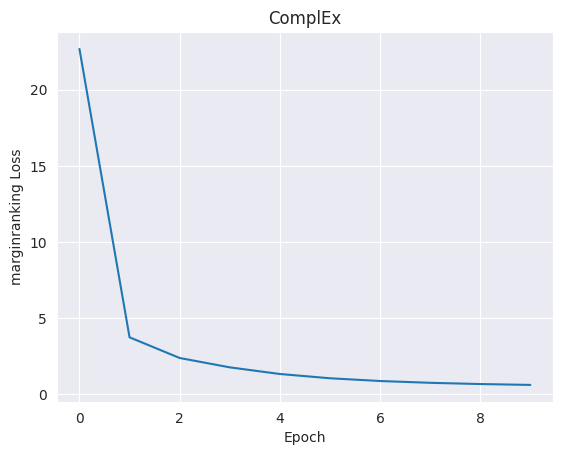

In [16]:
pipeline_result.plot_losses()

### Compute scores for given triplets

In [19]:
# compute scores for positive and negative triplets 
batch_size = 512

n = train.size(0) // batch_size
pos_train_preds = []
for i in range(n+1):
    start_idx = i*batch_size
    end_idx = min((i+1)*batch_size, train.size(0))
    edge = train[start_idx:end_idx]
    pos_train_preds += [pipeline_result.model.score_hrt(edge).squeeze().cpu().detach()]
pos_train_pred = torch.cat(pos_train_preds, dim=0)

n = valid.size(0) // batch_size
pos_valid_preds = []
for i in range(n+1):
    start_idx = i*batch_size
    end_idx = min((i+1)*batch_size, valid.size(0))
    edge = valid[start_idx:end_idx]
    pos_valid_preds += [pipeline_result.model.score_hrt(edge).squeeze().cpu().detach()]
pos_valid_pred = torch.cat(pos_valid_preds, dim=0)

n = valid_neg.size(0) // batch_size
neg_valid_preds = []
for i in range(n+1):
    start_idx = i*batch_size
    end_idx = min((i+1)*batch_size, valid_neg.size(0))
    edge = valid_neg[start_idx:end_idx]
    neg_valid_preds += [pipeline_result.model.score_hrt(edge).squeeze().cpu().detach()]
neg_valid_pred = torch.cat(neg_valid_preds, dim=0)

n = test.size(0) // batch_size
pos_test_preds = []
for i in range(n+1):
    start_idx = i*batch_size
    end_idx = min((i+1)*batch_size, test.size(0))
    edge = test[start_idx:end_idx]
    pos_test_preds += [pipeline_result.model.score_hrt(edge).squeeze().cpu().detach()]
pos_test_pred = torch.cat(pos_test_preds, dim=0)

n = test_neg.size(0) // batch_size
neg_test_preds = []
for i in range(n+1):
    start_idx = i*batch_size
    end_idx = min((i+1)*batch_size, test_neg.size(0))
    edge = test_neg[start_idx:end_idx]
    neg_test_preds += [pipeline_result.model.score_hrt(edge).squeeze().cpu().detach()]
neg_test_pred = torch.cat(neg_test_preds, dim=0)

In [20]:
print(f'Score ranges train: {torch.min(pos_train_pred)} - {torch.max(pos_train_pred)}')
print(f'Score ranges valid: {torch.min(pos_valid_pred)} - {torch.max(pos_valid_pred)}')
print(f'Score ranges valid neg: {torch.min(neg_valid_pred)} - {torch.max(neg_valid_pred)}')
print(f'Score ranges test: {torch.min(pos_test_pred)} - {torch.max(pos_test_pred)}')
print(f'Score ranges test neg: {torch.min(neg_test_pred)} - {torch.max(neg_test_pred)}')

Score ranges train: -14.636493682861328 - 16.131366729736328
Score ranges valid: -13.862576484680176 - 14.95986557006836
Score ranges valid neg: -11.937215805053711 - 14.936182022094727
Score ranges test: -12.03475284576416 - 14.889650344848633
Score ranges test neg: -13.35513687133789 - 15.168292999267578


### Evaluate my results

In [21]:
# Evaluate the coputed scores - hits@K

evaluator = Evaluator(name = 'ogbl-ddi')

results = {}
for K in [10, 20, 30]:
    evaluator.K = K
    train_hits = evaluator.eval({
        'y_pred_pos': pos_train_pred,
        'y_pred_neg': neg_valid_pred,
    })[f'hits@{K}']
    valid_hits = evaluator.eval({
        'y_pred_pos': pos_valid_pred,
        'y_pred_neg': neg_valid_pred,
    })[f'hits@{K}']
    test_hits = evaluator.eval({
        'y_pred_pos': pos_test_pred,
        'y_pred_neg': neg_test_pred,
    })[f'hits@{K}']
    
    results[f'Hits@{K}'] = (train_hits, valid_hits, test_hits)
    
    
for hits, result in results.items():
    print(hits)
#     print(result)
    train_hits, valid_hits, test_hits = result
    print(f'Train: {100 * train_hits:.2f}%')
    print(f'Valid: {100 * valid_hits:.2f}%')
    print(f'Test: {100 * test_hits:.2f}%')


Hits@10
Train: 0.01%
Valid: 0.01%
Test: 0.00%
Hits@20
Train: 0.02%
Valid: 0.02%
Test: 0.02%
Hits@30
Train: 0.03%
Valid: 0.04%
Test: 0.03%


In [23]:
print(pipeline_result.get_metric('hits@1'))
print(pipeline_result.get_metric('hits@5'))
print(pipeline_result.get_metric('hits@10'))

0.011735049329907333
0.05414303800313135
0.09127718388781098


In [25]:
print(pipeline_result.get_metric('mrr'))

0.04102858901023865


### BioKG dataset

In [3]:
dataset = PygLinkPropPredDataset(name='ogbl-biokg', root=dataset_dir, transform=T.ToSparseTensor())
data = dataset[0]
data

Data(
  num_nodes_dict={
    disease=10687,
    drug=10533,
    function=45085,
    protein=17499,
    sideeffect=9969
  },
  edge_index_dict={
    (disease, disease-protein, protein)=[2, 73547],
    (drug, drug-disease, disease)=[2, 5147],
    (drug, drug-drug_acquired_metabolic_disease, drug)=[2, 63430],
    (drug, drug-drug_bacterial_infectious_disease, drug)=[2, 18554],
    (drug, drug-drug_benign_neoplasm, drug)=[2, 30348],
    (drug, drug-drug_cancer, drug)=[2, 48514],
    (drug, drug-drug_cardiovascular_system_disease, drug)=[2, 94842],
    (drug, drug-drug_chromosomal_disease, drug)=[2, 316],
    (drug, drug-drug_cognitive_disorder, drug)=[2, 34660],
    (drug, drug-drug_cryptorchidism, drug)=[2, 128],
    (drug, drug-drug_developmental_disorder_of_mental_health, drug)=[2, 14314],
    (drug, drug-drug_endocrine_system_disease, drug)=[2, 55994],
    (drug, drug-drug_fungal_infectious_disease, drug)=[2, 36114],
    (drug, drug-drug_gastrointestinal_system_disease, drug)=[2, 83210

In [4]:
split_edge = dataset.get_edge_split()
train_triples, valid_triples, test_triples = split_edge["train"], split_edge["valid"], split_edge["test"]

In [ ]:
int(max(train_triples['relation']))+1

train_triples (valid/test):
* head type (e.g. disease)
* head - tensor
* relation - tensor
* tail type (e.g. protein)
* tail - tensor


In [5]:
# relation_name_id = data['edge_index_dict'].keys()
head = train_triples['head']
relation = train_triples['relation']
tail = train_triples['tail']
train_df = pd.DataFrame({'head': head, 'relation': relation, 'tail': tail})
print(train_df.head())

head = valid_triples['head']
relation = valid_triples['relation']
tail = valid_triples['tail']
valid_df = pd.DataFrame({'head': head, 'relation': relation, 'tail': tail})


head = test_triples['head']
relation = test_triples['relation']
tail = test_triples['tail']
test_df = pd.DataFrame({'head': head, 'relation': relation, 'tail': tail})


    head  relation   tail
0   1718         0   3207
1   4903         0  13662
2   5480         0  15999
3   3148         0   7247
4  10300         0  16202


In [6]:
num_entities = sum(dataset[0]['num_nodes_dict'].values())
num_relations = int(max(train_triples['relation']))+1

In [8]:
train_tf = convert_to_triples_factory(torch.tensor(train_df.values), num_entities, num_relations)
valid_tf = convert_to_triples_factory(torch.tensor(valid_df.values), num_entities, num_relations)
test_tf = convert_to_triples_factory(torch.tensor(test_df.values), num_entities, num_relations)

CoreTriplesFactory(num_entities=93773, num_relations=51, create_inverse_triples=False, num_triples=4762678)
CoreTriplesFactory(num_entities=93773, num_relations=51, create_inverse_triples=False, num_triples=162886)
CoreTriplesFactory(num_entities=93773, num_relations=51, create_inverse_triples=False, num_triples=162870)


In [10]:
dir_data_my_split = dataset_dir + 'ogbl_biokg-my_split/'

train_df.to_csv(dir_data_my_split + 'train.txt', sep='\t', header=False, index=False)
valid_df.to_csv(dir_data_my_split + 'valid.txt', sep='\t', header=False, index=False)
test_df.to_csv(dir_data_my_split + 'test.txt', sep='\t', header=False, index=False)

In [11]:
model_name = 'ComplEx'
specification = 'ogb-biokg-text'

pipeline = pipeline(
            training = '../data/dataset-ogb/ogbl_biokg-my_split/train.txt',
            validation = '../data/dataset-ogb/ogbl_biokg-my_split/valid.txt',
            testing = '../data/dataset-ogb/ogbl_biokg-my_split/test.txt',
            model = model_name,
            model_kwargs = dict(
                embedding_dim = 1000
            ),
            loss = 'MarginRankingLoss',
            optimizer = 'Adam',
            optimizer_kwargs = dict(
                lr = 0.001
            ),
            evaluator = 'rankbased',
            device = 'gpu',
            training_kwargs = dict(
                batch_size = 100,
                num_epochs = 1,
#                 checkpoint_name = model_name + '-' + specification + '_checkpoint.pt',
#                 checkpoint_directory = 'kg_checkpoints'
            ),
        )  

No random seed is specified. Setting to 991145354.


Training epochs on cuda:0:   0%|          | 0/1 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/47627 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=16.


Evaluating on cuda:0:   0%|          | 0.00/163k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 657.97s seconds


<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

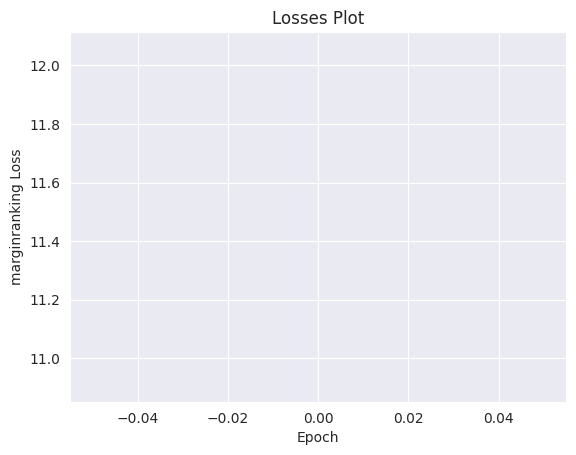

In [12]:
pipeline.plot_losses()

In [13]:
pipeline.metric_results.to_df()

,Side,Type,Metric,Value
0,head,optimistic,standard_deviation,13934.920103
1,tail,optimistic,standard_deviation,13891.449100
2,both,optimistic,standard_deviation,13913.708163
3,head,realistic,standard_deviation,13934.919922
4,tail,realistic,standard_deviation,13891.450195
...,...,...,...,...
220,tail,realistic,adjusted_hits_at_k,0.034316
221,both,realistic,adjusted_hits_at_k,0.035152
222,head,pessimistic,adjusted_hits_at_k,0.035988
223,tail,pessimistic,adjusted_hits_at_k,0.034316


In [14]:
pipeline.get_metric('mrr')

0.013583026826381683

In [15]:
from collections import defaultdict

def test_step(trained_model, test_triplets, num_entities, num_relations):   
    evaluator = Evaluator(name = 'ogbl-biokg')
    
    batch_size = 512
    
    test_logs = defaultdict(list)
    
    n = test_triplets['head'].size(0) // batch_size
    test_dataset = []
    for i in range(n+1):
        start_idx = i*batch_size
        end_idx = min((i+1)*batch_size, test_triplets['head'].size(0))
        positive_triples = torch.stack([test_triples['head'][start_idx:end_idx], 
                                        test_triples['relation'][start_idx:end_idx], 
                                        test_triples['tail'][start_idx:end_idx]], 1)
        
        num_neg = test_triples['head_neg'][start_idx:end_idx].size(0)
        neg_nodes = test_triples['head_neg'].shape[1]
        
        negative_triples = torch.stack([test_triples['head_neg'][start_idx:end_idx], 
                                        torch.randint(0, num_relations, (num_neg, neg_nodes)), 
                                        test_triples['tail_neg'][start_idx:end_idx]], 1)

        test_dataset.append((positive_triples, negative_triples))

    
    with torch.no_grad():
        for positive_sample, negative_sample in test_dataset:
            positive_sample = positive_sample.cuda()
            negative_sample = negative_sample.cuda()

            score = trained_model.model.score_hrt(positive_sample)
            score_neg = trained_model.model.score_hrt(negative_sample)


            batch_results = evaluator.eval({'y_pred_pos': score[:, 0], 
                                        'y_pred_neg': score_neg.squeeze(-1)})
            for metric in batch_results:
                test_logs[metric].append(batch_results[metric])

    metrics = {}
    for metric in test_logs:
        metrics[metric] = torch.cat(test_logs[metric]).mean().item()
        
    return metrics    

In [17]:
metrics = test_step(pipeline, valid_triples, num_entities, num_relations)

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.91 GiB (GPU 0; 7.79 GiB total capacity; 4.18 GiB already allocated; 1.88 GiB free; 5.75 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
metrics